In [ ]:
# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [ ]:
import glob 
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
%matplotlib inline
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout,Bidirectional,GRU,Reshape,Input,InputLayer,Activation
import tensorflow as tf
import tensorflow.keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
from sklearn.metrics import roc_curve,confusion_matrix,roc_auc_score, precision_score, recall_score, accuracy_score



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# GPU check
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [ ]:
#Getting X
paths = '/content/drive/My Drive/transformer_code/archive/data'
csv_files = glob.glob(f"{paths}/*.wav")
#csv_files.remove(f"{paths}/files.wav")
csv_files.sort()
total_X = []
for csv in csv_files:
  audio_data, sr = librosa.load(csv)
  # short time fourier transform
  stft = librosa.stft(audio_data,n_fft=478,hop_length=221,window='hann',center=True)
  Xdb = librosa.amplitude_to_db(stft).T
  # standardisation
  mean = Xdb.mean()
  deviation = Xdb.std()
  standard_value = (Xdb-mean)/deviation
  X1 = []
  for i in range(len(Xdb)):
      array = []
      result = []
      for j in range(len(standard_value[0])):
        array.append(standard_value[i][j])
        if j%4 == 0:
          result.append(max(array))
          array = []
      X1.append(result)
  X = np.array(X1).reshape(200,15,4)
  total_X.append(X)
  print(len(total_X))
X = np.abs((np.array(total_X)))

In [ ]:
X

In [ ]:
print(X.shape)

(1606, 200, 15, 4)


In [ ]:
#Saving X
np.save(f"/content/drive/My Drive/transformer_code/data_copy/X.npy", X)

NameError: ignored

In [ ]:
#Getting Y
path_save = '/content/drive/My Drive/transformer_code/data_copy/Y.csv'
Y = pd.read_csv(path_save).T

In [ ]:
#Getting X
path_x = '/content/drive/My Drive/transformer_code/data_copy/X.npy'
X = np.load(path_x)
print(X.shape)

(1606, 200, 15, 4)


In [ ]:
#Splite data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#X_test, X_validate, Y_test, Y_validate = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)


In [ ]:
# CNN + GRU
model = Sequential()
model.add(InputLayer(input_shape=(200,15,4,1)))
model.add(Conv2D(30, kernel_size=3, 
activation='relu',
input_shape = (15,4,1)
))
model.add(Conv2D(60, kernel_size=(4,2),
activation='relu' ))
model.add(Flatten())
model.add(Reshape((200,600)))
model.add(Dropout(0.4)) # 03/08/2002 -Chen 
model.add(Bidirectional(GRU(units=80, input_shape=(200,600),activation='relu',return_sequences=True)))
model.add(Dropout(0.4))
model.add(Dense(1,activation = 'sigmoid'))
#model.add(Activation( activation = 'sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer='ADAM',
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 13, 2, 30)    300       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 10, 1, 60)    14460     
                                                                 
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 reshape (Reshape)           (None, 200, 600)          0         
                                                                 
 dropout (Dropout)           (None, 200, 600)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 160)         327360    
 l)                                                              
                                                        

In [ ]:
# Sample length
print(len(Y_train))

1284


In [ ]:
#tf.config.experimental_run_functions_eagerly(True)
epochs = 50
history = model.fit(X_train,Y_train, batch_size = 21, epochs = epochs, validation_data=[X_test,Y_test])

Epoch 1/50
62/62 [==============================] - 70s 891ms/step - loss: 0.3090 - accuracy: 0.9084 - recall: 0.0243 - precision: 0.1305 - val_loss: 0.2285 - val_accuracy: 0.9261 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
62/62 [==============================] - 54s 875ms/step - loss: 0.2274 - accuracy: 0.9242 - recall: 0.1017 - precision: 0.7035 - val_loss: 0.1899 - val_accuracy: 0.9351 - val_recall: 0.2282 - val_precision: 0.6813
Epoch 3/50
62/62 [==============================] - 53s 862ms/step - loss: 0.1938 - accuracy: 0.9355 - recall: 0.3040 - precision: 0.7427 - val_loss: 0.1768 - val_accuracy: 0.9413 - val_recall: 0.2805 - val_precision: 0.7881
Epoch 4/50
62/62 [==============================] - 53s 855ms/step - loss: 0.1760 - accuracy: 0.9429 - recall: 0.4014 - precision: 0.7845 - val_loss: 0.1510 - val_accuracy: 0.9481 - val_recall: 0.4232 - val_precision: 0.7714
Epoch 5/50
62/62 [==============================] - 53s 851ms/step - loss: 0.1608 - accuracy

In [ ]:
 # Evaluate accurancy
train_acc, train_loss, val_acc, val_loss = history.history['accuracy'], history.history['loss'],  history.history['val_accuracy'], history.history['val_loss']
print('train_acc:'+str(np.mean(train_acc)))
print('train_loss:'+str(np.mean(train_loss)))
print('val_acc:'+str(np.mean(val_acc)))
print('val_loss:'+str(np.mean(val_loss)))

NameError: ignored

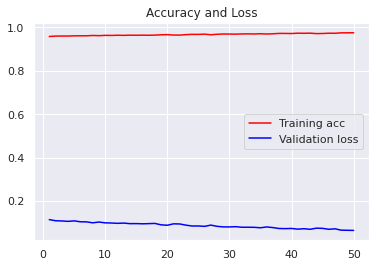

In [ ]:
# ACC
epochs = range(1, len(train_acc) + 1) 
plt.title('Accuracy and Loss')
plt.plot(epochs, train_acc, 'red', label='Training acc')
plt.plot(epochs, train_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

In [ ]:
#Save model
# model.save('my_model')
# model.save('/content/drive/My Drive/transformer_code/model/my_model')

In [ ]:
#Load model
#model = tf.keras.models.load_model('my_model')
model.save('/content/drive/My Drive/transformer_code/model/my_model')

In [ ]:
#Test by validate data
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9655591249465942


In [ ]:
#one hot
y_true = Y_test.values.ravel()
y_probas = model.predict(X[0]).reshape(-1,200).ravel()
for i in range(len(y_probas)):
  if y_probas[i] < 0.5:
     y_probas[i] = 0
  else:
     y_probas[i] = 1

Total values :64400
[[ 3180  1579]
 [  639 59002]]


Text(30.5, 0.5, 'ground')

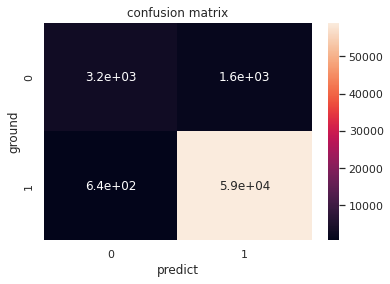

In [ ]:
#Confusion matrix
print("Total values :"+str(len(y_probas)))
f,ax=plt.subplots()
C2= confusion_matrix(y_true, y_probas,labels=[1,0])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 

ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('ground') #y轴

In [ ]:
# precision, recall
#r = round(59230/(59230+2985),2)
#p = round(59230/(59230+411),2)
p = precision_score(y_true, y_probas)
r = recall_score(y_true, y_probas)
f1score = f1_score(y_true, y_probas)
print("precision is "+str(p))
print("recall is "+str(r))
print("f1 is "+str(f1score))

precision is 0.8326787117046347
recall is 0.6682076066400504
f1 is 0.7414315691303334


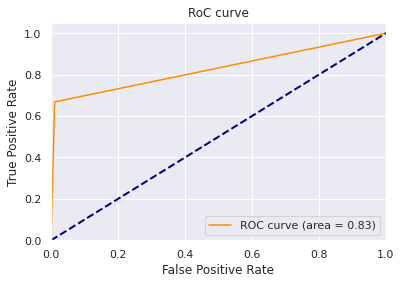

In [ ]:
fpr, tpr, threshold = roc_curve(y_true, y_probas)
auc = roc_auc_score(y_true,y_probas)
plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoC curve')
plt.legend(loc="lower right")
plt.savefig('suhan.jpg',dpi=800)
plt.show()

In [ ]:
X_result = X[0].reshape(-1,200,15,4)
Y_result = model.predict(X_result)

In [ ]:
count = 0
for i in Y_result:
  # print(i)
    for j in i:
      if j[0] >= 0.1:
        count += 1
        print(j[0])
print("\ncount:", count)
  #if float(i[0][0]) >= 0.1:
   # print("i")

0.2321852
0.10006497
0.7735527
0.10145891
0.18766837
0.6251598
0.28789404
0.13828437
0.12778269

count: 9


In [ ]:
#print(X[0].reshape(-1,200,15,4).shape)
y_probas = model.predict(X[2].reshape(-1,200,15,4)).reshape(-1,200).ravel()
for i in range(len(y_probas)):
  if y_probas[i] < 0.5:
     y_probas[i] = 0
  else:
     y_probas[i] = 1
print(y_probas)
print(len([x for x in y_probas if x ==1]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
5
